# Разработка модели прогнозирования рыночной стоимости автомобиля для сервиса «Не бит, не крашен»

Целью проекта является создание модели, которая обеспечит высокое качество предсказаний рыночной стоимости автомобилей для платформы "Не бит, не крашен". На основе исторических данных о технических характеристиках, комплектациях и ценах автомобилей, модель будет обладать высокой скоростью как обучения, так и предсказания, что позволит пользователям быстро и удобно получать информацию о цене своего транспортного средства.

**Описание данных:**

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

**Этапы работы**

1. [Подготовка данных](#Подготовка-данных)
2. [Обучение моделей](#Обучение-моделей)
3. [Анализ моделей](#Анализ-моделей)
4. [Общий вывод](#Общий-вывод)

In [1]:
!pip install -U scikit-learn -q
!pip install phik -q
!pip install lightgbm -q
!pip install catboost -q

In [2]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import time

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor

import warnings

warnings.filterwarnings("ignore")

In [3]:
RANDOM_STATE = 17

In [4]:
def build_bar_plot(df, col, xlabel, title):
    """
    Строит столбчатую диаграмму для анализа распределения категориальной переменной.

    Параметры:
    - df: DataFrame, содержащий данные.
    - col: Название столбца, для которого строится диаграмма.
    - xlabel: Подпись оси x.
    - title: Название графика.

    Пример:
    ```
    build_bar_plot(data, 'department', 'Отделы', 'Распределение сотрудников по отделам')
    ```

    """
    plt.figure(figsize=(10, 7))
    
    # Получаем топ-10 наиболее популярных значений столбца
    top_10_values = df[col].value_counts().nlargest(10).index
    
    # Фильтруем данные по этим значениям
    filtered_df = df[df[col].isin(top_10_values)]
    
    # Строим график на отфильтрованных данных
    ax = sns.countplot(x=filtered_df[col], order=top_10_values, color='steelblue')
    
    plt.ylabel('Кол-во автомобилей')
    plt.xlabel(xlabel)
    plt.title(title)
    
    total = len(df[col])  # общее количество элементов в столбце
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')
        
    plt.xticks(rotation=0)
    plt.show()
    
    
    
def build_hist_box_plot(df, col, xlabel, title):
    """
    Строит гистограмму и бокс-плот для анализа распределения числовой переменной.

    Параметры:
    - df: DataFrame, содержащий данные.
    - col: Название столбца, для которого строится гистограмма и бокс-плот.
    - xlabel: Подпись оси x.
    - title: Название графика.

    Пример:
    ```
    build_hist_box_plot(data, 'age', 'Возраст', 'Распределение возраста в компании')
    ```

    """
    plt.figure(figsize=(13, 7))
    
    
    plt.subplot(1, 2, 1)
    sns.histplot(x=df[col], kde=False, bins=30)
    plt.ylabel('Кол-во автомобилей')
    plt.xlabel(xlabel)
    
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.ylabel('')
    plt.xlabel(xlabel)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    display(df[col].describe())


## Подготовка данных

### Загрузка данных

In [5]:
try:
    autos = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    print('There is no such file')

In [6]:
display(autos.sample(5))
autos.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
53794,2016-03-08 12:47:14,5900,suv,2007,manual,136,captiva,100000,8,petrol,chevrolet,no,2016-03-08,0,81241,2016-03-12 05:17:33
234078,2016-03-24 09:37:19,3950,sedan,1988,auto,113,NaN,150000,6,petrol,volvo,no,2016-03-24,0,75203,2016-04-02 23:16:54
143169,2016-03-28 10:55:41,3800,small,2008,manual,69,c1,80000,2,petrol,citroen,no,2016-03-28,0,87724,2016-04-06 12:45:23
257658,2016-03-28 20:44:22,2600,small,2003,manual,75,corsa,150000,9,petrol,opel,no,2016-03-28,0,63457,2016-04-07 03:15:20
88521,2016-03-09 11:56:37,3890,convertible,2001,manual,163,slk,150000,9,petrol,mercedes_benz,no,2016-03-09,0,58313,2016-03-29 10:46:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

**Мы успешно завершили процесс загрузки данных и обнаружили наличие пропущенных значений в них.**

### Проверка данных на наличие дубликатов

In [7]:
print(f'Количество явных дубликатов: {autos.duplicated().sum()}')

Количество явных дубликатов: 4


In [8]:
autos.drop_duplicates(inplace=True)

**В предоставленных данных были обнаружены и удалены дубликаты.**

### Работа с пропусками

In [9]:
print(autos['VehicleType'].unique())
autos['VehicleType'].fillna('other', inplace=True)

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


Вероятные пропуски в типе кузова могут быть обусловлены отсутствием соответствующей категории на сервисе. Поэтому присвоим пропущенным значениям типа кузова значение `other`.

In [10]:
print(autos['Gearbox'].unique())
autos['Gearbox'].fillna('unknown', inplace=True)

['manual' 'auto' nan]


В данном случае отсутствуют логически обоснованные альтернативы. Поэтому присвоим пропущенным значениям типа кузова значение `unknown`.

In [11]:
print(autos['Model'].unique())
autos['Model'].fillna('other', inplace=True)

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

Вероятные пропуски в модели автомобиля также могут быть обусловлены отсутствием соответствующей модели на сервисе. Поэтому пропущенным значениям будет присвоено значение `other`.

In [12]:
print(autos['FuelType'].unique())
autos['FuelType'].fillna('other', inplace=True)

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


Для типа топлива применим аналогичный подход.

In [13]:
print(autos['Repaired'].unique())
autos['Repaired'].fillna('no', inplace=True)

[nan 'yes' 'no']


Предположительно, значение nan в данном признаке указывает на отсутствие проведенных ремонтных работ.

### Исследовательский анализ данных

**Категориальные признаки**

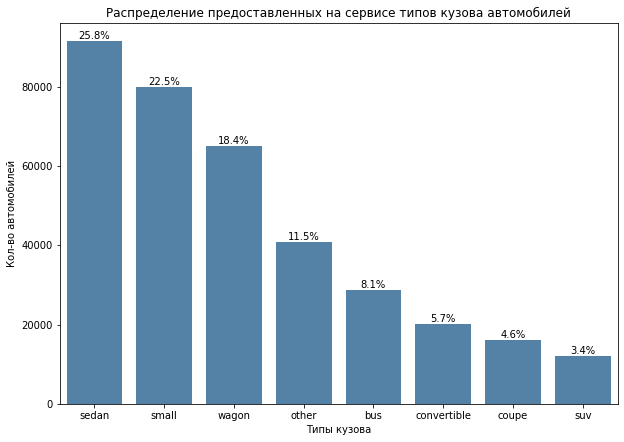

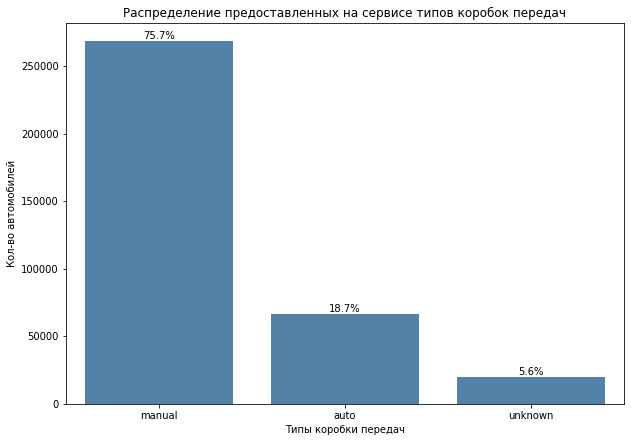

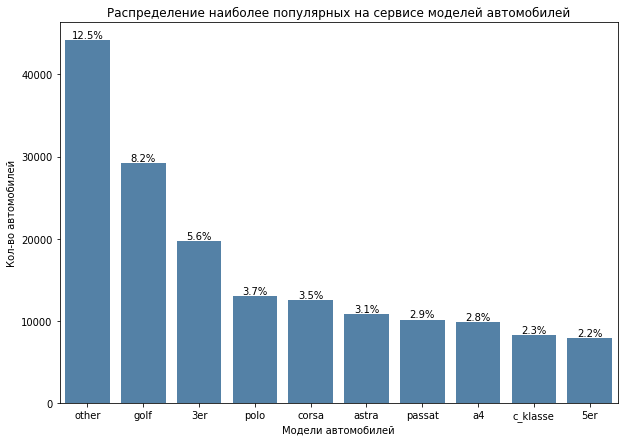

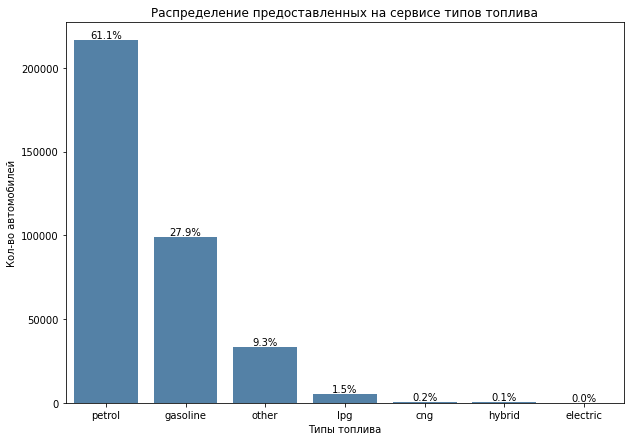

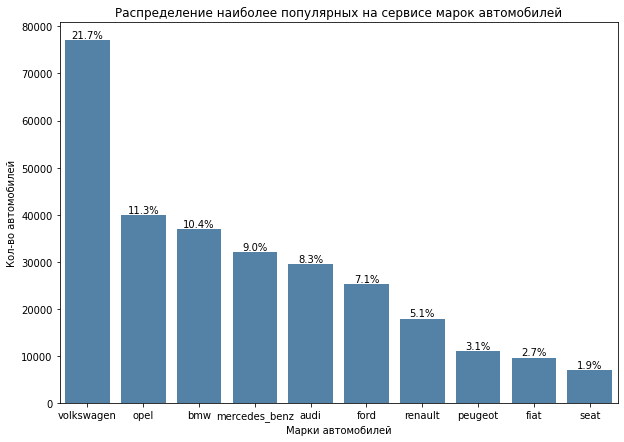

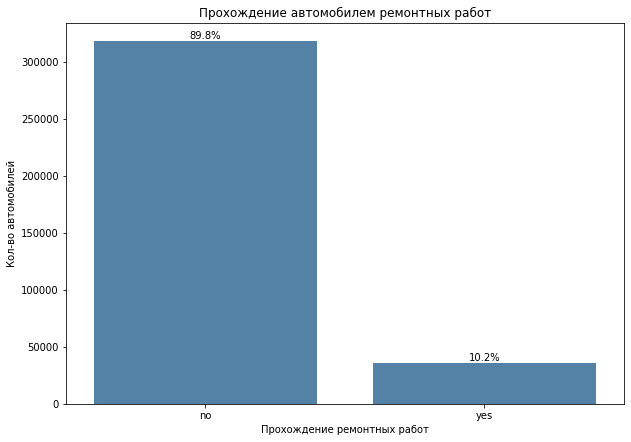

In [14]:
build_bar_plot(autos, 'VehicleType', 'Типы кузова', 'Распределение предоставленных на сервисе типов кузова автомобилей')
build_bar_plot(autos, 'Gearbox', 'Типы коробки передач', 'Распределение предоставленных на сервисе типов коробок передач')
build_bar_plot(autos, 'Model', 'Модели автомобилей', 'Распределение наиболее популярных на сервисе моделей автомобилей')
build_bar_plot(autos, 'FuelType', 'Типы топлива', 'Распределение предоставленных на сервисе типов топлива')
build_bar_plot(autos, 'Brand', 'Марки автомобилей', 'Распределение наиболее популярных на сервисе марок автомобилей')
build_bar_plot(autos, 'Repaired', 'Прохождение ремонтных работ', 'Прохождение автомобилем ремонтных работ')

- Наиболее популярными типами кузова являются: sedan(25.8%), small(22.5%) и wagon(18.4%)



- На сервисе преобладают автомобили с механической коробки передач, соотношение составляет 75.7% по сравнению с 18.7% у автоматической коробки передач.



- Наиболее популярными моделями автомобиля являются: other(12.5%), golf(8.2%) и 3er(5.6%)



- Наиболее популярные типы топлива: petrol(61.1%), gasoline(27.9%) и other(9.3%)



- Наиболее популярными марками автомобиля являются: volkswagen(21.7%), opel(11.3%) и bmw(10.4%)



- Наибольшее количество автомобилей (89.8%) не проходили ремонтные работы, в сравнении с 10.2% автомобилей, которые прошли.

**Количественные признаки**

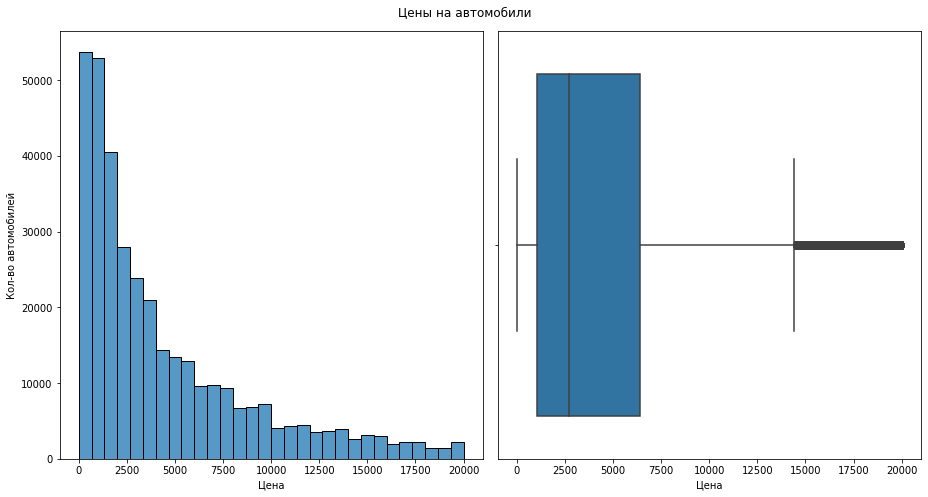

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [15]:
build_hist_box_plot(autos, 'Price', 'Цена', 'Цены на автомобили')

Исключим из дальнейшего анализа автомобили, цена которых составляет менее 50 евро, поскольку это вероятно является ошибкой.

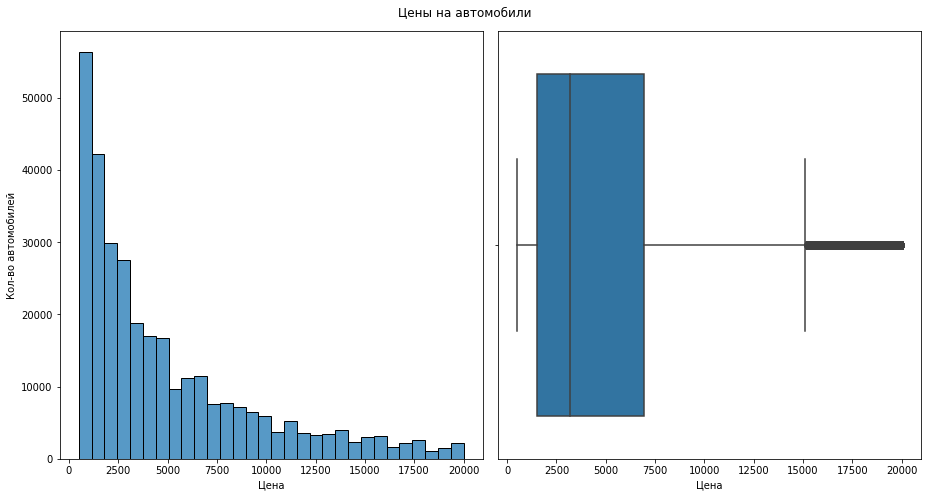

count    318311.000000
mean       4895.114881
std        4520.278157
min         500.000000
25%        1499.000000
50%        3200.000000
75%        6950.000000
max       20000.000000
Name: Price, dtype: float64

In [16]:
autos = autos.drop(autos[autos['Price'] < 500].index)
build_hist_box_plot(autos, 'Price', 'Цена', 'Цены на автомобили')

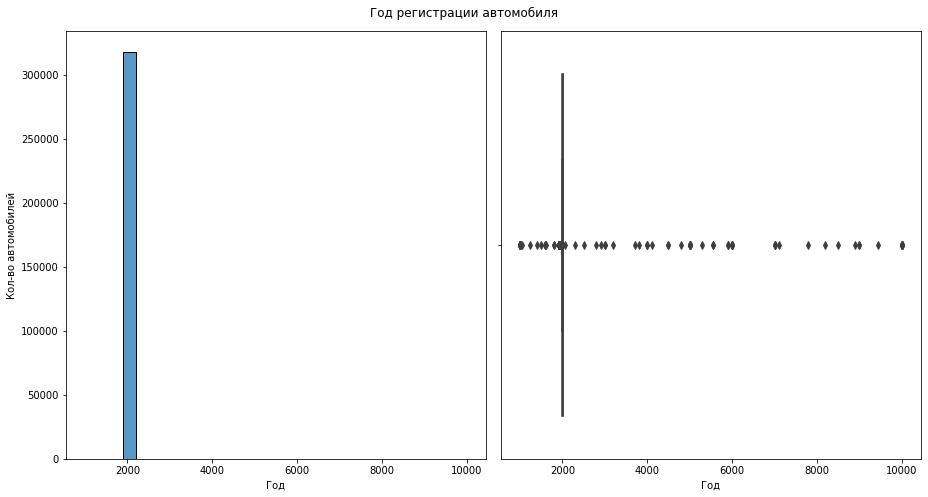

count    318311.000000
mean       2004.164672
std          65.378165
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [17]:
build_hist_box_plot(autos, 'RegistrationYear', 'Год', 'Год регистрации автомобиля')

Для дальнейшего анализа оставим только те автомобили, которые были зарегистрированы в период с 1970 по 2024 год, чтобы исключить большое количество аномальных значений по году регистрации.

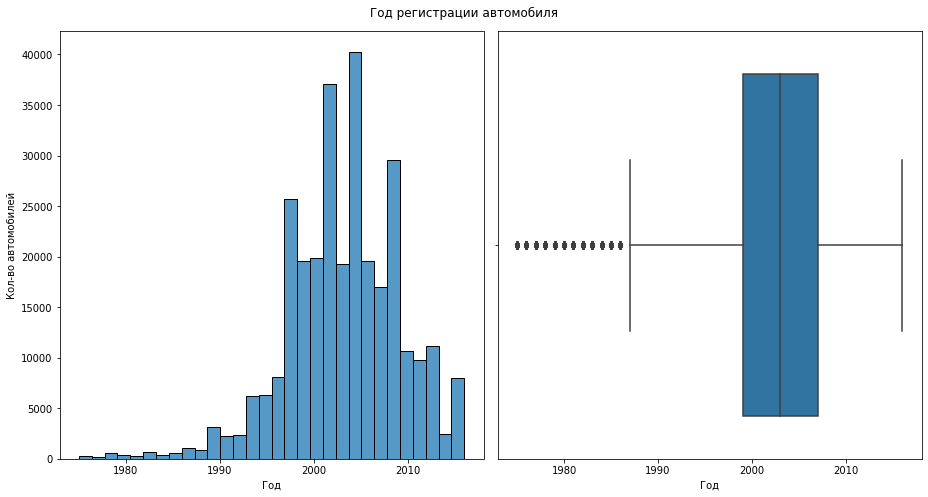

count    303291.000000
mean       2003.137337
std           6.053962
min        1975.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

In [18]:
autos = autos.drop(autos[(autos['RegistrationYear'] < 1975) |
                         (autos['RegistrationYear'] > autos['DateCrawled'].dt.year.max())].index)
build_hist_box_plot(autos, 'RegistrationYear', 'Год', 'Год регистрации автомобиля')

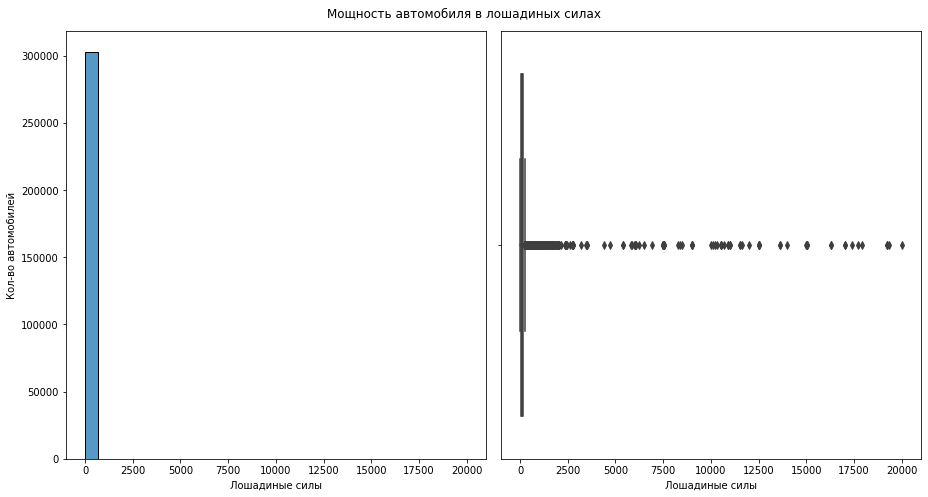

count    303291.000000
mean        116.264228
std         185.286511
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: Power, dtype: float64

In [19]:
build_hist_box_plot(autos, 'Power', 'Лошадиные силы', 'Мощность автомобиля в лошадиных силах')

Также уберём аномальные значения по признаку лошадиных сил и установим ограничение от 6 до 1600 лошадиных сил. Аномальные значения заполним медианным по модели.

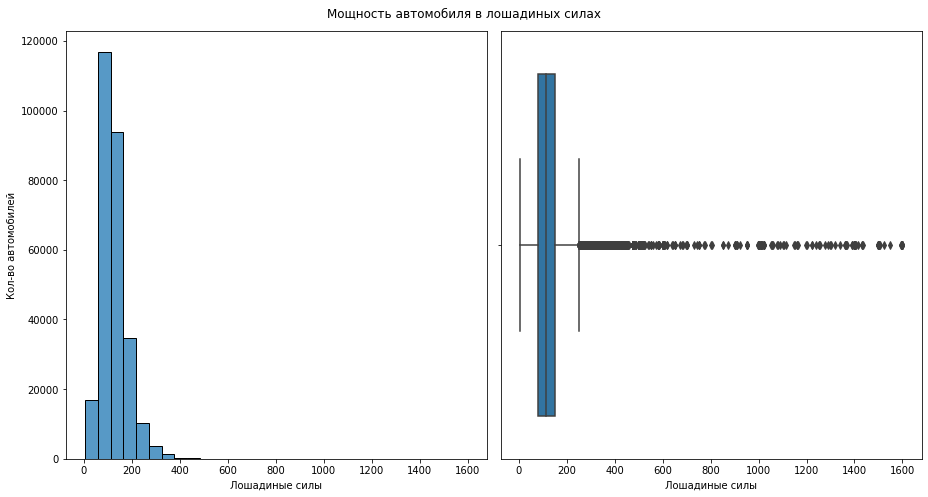

count    278095.000000
mean        123.666075
std          58.531127
min           6.000000
25%          82.000000
50%         116.000000
75%         150.000000
max        1600.000000
Name: Power, dtype: float64

In [20]:
autos = autos.drop(autos[(autos['Power'] < 6) | (autos['Power'] > 1600)].index)
build_hist_box_plot(autos, 'Power', 'Лошадиные силы', 'Мощность автомобиля в лошадиных силах')

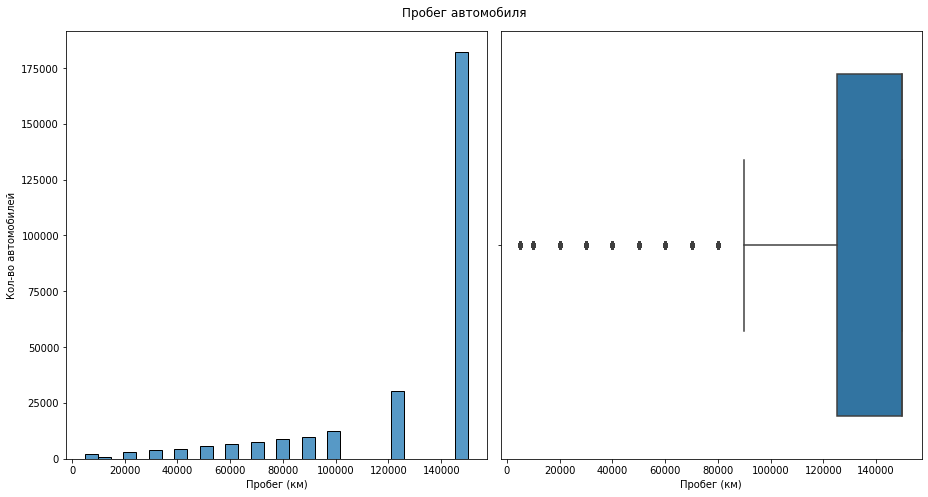

count    278095.000000
mean     127918.984520
std       36743.663655
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [21]:
build_hist_box_plot(autos, 'Kilometer', 'Пробег (км)', 'Пробег автомобиля')

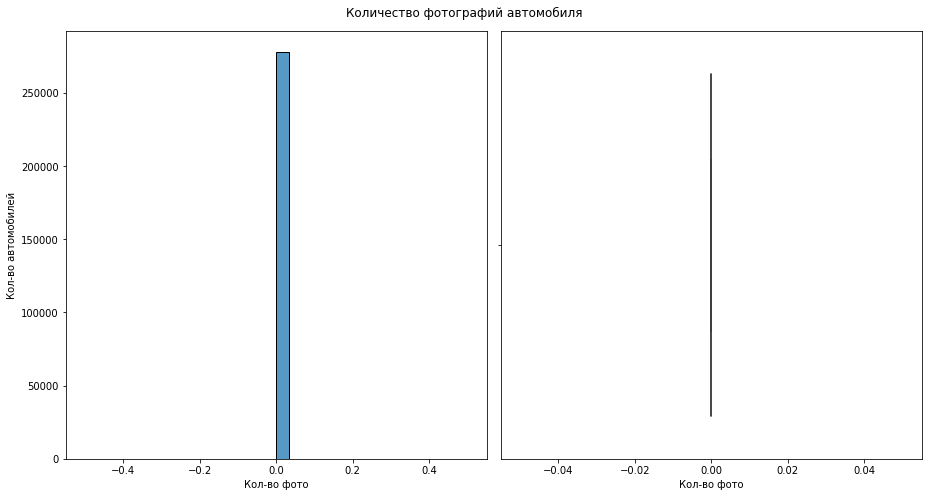

count    278095.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

In [22]:
build_hist_box_plot(autos, 'NumberOfPictures', 'Кол-во фото', 'Количество фотографий автомобиля')

**После исключения аномальных значений мы можем сделать следующие выводы:**
- **Цены на автомобили**: цены варьируются от 500 до 20 000 евро, с медианным значением в 3200 евро.
- **Год регистрации**: год варьируется от 1975 до 2016, с медианным и средним значением в 2003.
- **Мощность автомобиля**: мощность варьируется от 6 до 1600 лс с медианой в 116 лс.
- **Пробег**: пробег автомобилей варьируется от 5000 до 150 000 км, с медианным значением в 150000 км. Заметно преобладание машин с большим пробегом..
- **Количество фотографий автомобиля**: интересной особенностью является полное отсутствие фотографий в объявлениях. Вероятно, это связано с ошибкой при выгрузке данных.

Колонки DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen не представляют существенной информации для нашего исследования. Их можно удалить.

In [23]:
autos = autos.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

### Корреляционный анализ

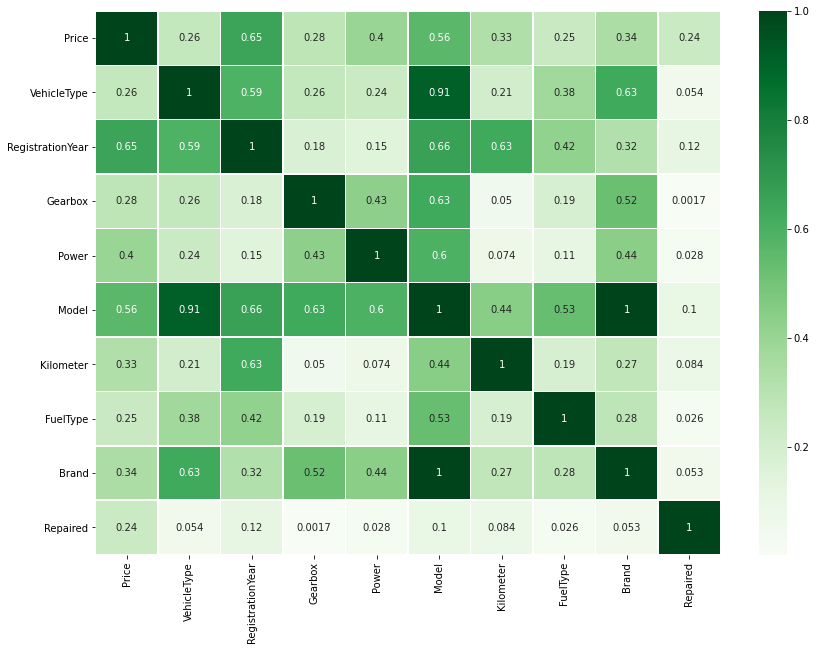

In [24]:
plt.figure(figsize=(14, 10))
interval_columns = ['Price', 'Power']
sns.heatmap(autos.phik_matrix(interval_cols=interval_columns), annot=True, cmap='Greens', linewidths=0.5);

**Наибольшая корреляция с целевым признаком наблюдается у следующих показателей:**
1) Год регистрации автомобиля - 0.65

2) Модель автомобиля - 0.56

3) Мощность автомобиля - 0.4

**Выявлена мультиколлинеарность между столбцами `Model` и `Brand`, где коэффициент корреляции равен 1. В связи с этим удалим столбец с маркой.**

In [25]:
autos = autos.drop('Brand', axis=1)

In [26]:
print(f'Количество явных дубликатов после коррекции данных: {autos.duplicated().sum()}')
autos.drop_duplicates(inplace=True)

Количество явных дубликатов после коррекции данных: 43619


## Обучение моделей

### Деление на выборки

In [27]:
features = autos.drop('Price', axis=1)
target = autos['Price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

categorical_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

### Тестирование моделей

**LinearRegression**

In [28]:
model_lr = LinearRegression()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ],
    remainder='passthrough' 
)
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor), 
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', model_lr) 
])


param_grid_lr = {
     'scaler': [StandardScaler(with_mean=False), RobustScaler(with_centering=False), None]
}


grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='neg_root_mean_squared_error')

start_training_time = time.time()
grid_search_lr.fit(features_train, target_train)
end_training_time = time.time()

best_pipeline_lr = grid_search_lr.best_estimator_

start_prediction_time_train = time.time()
target_predict_train = best_pipeline_lr.predict(features_train)
end_prediction_time_train = time.time()

prediction_time_train_lr = end_prediction_time_train - start_prediction_time_train
rmse_score_lr = grid_search_lr.best_score_ * -1
training_time_lr = end_training_time - start_training_time


print("Время обучения LinearRegression:", training_time_lr)
print("Время предсказания на тренировочной выборке:", prediction_time_train_lr)
print("RMSE LinearRegression:", rmse_score_lr)
print("Лучшая модель:")
print(best_pipeline_lr)

Время обучения LinearRegression: 110.38144898414612
Время предсказания на тренировочной выборке: 0.4380347728729248
RMSE LinearRegression: 2650.714833401103
Лучшая модель:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('regressor', LinearRegression())])


**DecisionTreeRegressor**

In [29]:
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ],
    remainder='passthrough' 
)


pipeline_dt = Pipeline([
    ('preprocessor', preprocessor), 
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', model_dt) 
])

param_grid_dt = {
    'scaler': [StandardScaler(with_mean=False), RobustScaler(with_centering=False), None],
    'regressor__max_depth': [5, 10, 15]
}

grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='neg_root_mean_squared_error')

start_time_dt = time.time()
grid_search_dt.fit(features_train, target_train)
end_time_dt = time.time()

best_pipeline_dt = grid_search_dt.best_estimator_

start_prediction_time_train = time.time()
target_predict_train = best_pipeline_dt.predict(features_train)
end_prediction_time_train = time.time()

prediction_time_train_dt = end_prediction_time_train - start_prediction_time_train
rmse_score_dt = grid_search_dt.best_score_ * -1
training_time_dt = end_time_dt - start_time_dt

print("Время обучения DecisionTreeRegressor:", training_time_dt)
print("Время предсказания на тренировочной выборке:", prediction_time_train_dt)
print("RMSE DecisionTreeRegressor:", rmse_score_dt)
print("Лучшая модель DecisionTreeRegressor:")
print(best_pipeline_dt)

Время обучения DecisionTreeRegressor: 112.20657873153687
Время предсказания на тренировочной выборке: 0.34612131118774414
RMSE DecisionTreeRegressor: 1940.9299146936187
Лучшая модель DecisionTreeRegressor:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('regressor',
                 DecisionTreeRegressor(max_depth=15, random_state=17))])


**LGBMRegressor**

In [30]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', model_lgbm)
])

param_grid_lgbm = {
    'scaler': [StandardScaler(with_mean=False), None],
    'regressor__num_leaves': [50, 100] 
}

grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=5, scoring='neg_root_mean_squared_error')

start_time_lgbm = time.time()
grid_search_lgbm.fit(features_train, target_train)
end_time_lgbm = time.time()

best_pipeline_lgbm = grid_search_lgbm.best_estimator_

start_prediction_time_train_lgbm = time.time()
target_predict_train_lgbm = best_pipeline_lgbm.predict(features_train)
end_prediction_time_train_lgbm = time.time()

prediction_time_train_lgbm = end_prediction_time_train_lgbm - start_prediction_time_train_lgbm
rmse_score_lgbm = grid_search_lgbm.best_score_ * -1
training_time_lgbm = end_time_lgbm - start_time_lgbm

print("Время обучения LGBMRegressor:", training_time_lgbm)
print("Время предсказания на тренировочной выборке:", prediction_time_train_lgbm)
print("RMSE LGBMRegressor:", rmse_score_lgbm)
print("Лучшая модель LGBMRegressor:")
print(best_pipeline_lgbm)


Время обучения LGBMRegressor: 596.8780810832977
Время предсказания на тренировочной выборке: 2.911189317703247
RMSE LGBMRegressor: 1644.9576656282275
Лучшая модель LGBMRegressor:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType',
                                                   'Repaired'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('regressor', LGBMRegressor(num_leaves=100, random_state=17))])


## Анализ моделей

### Сравнение моделей

In [31]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'LGBMRegressor']

data = {'RMSE':[rmse_score_lr,
                rmse_score_dt,
                rmse_score_lgbm],
        
        'Время обучения модели':[training_time_lr,
                                 training_time_dt,
                                 training_time_lgbm],
        
        'Время предсказания модели на тренировочных данных':[prediction_time_train_lr,
                                     prediction_time_train_dt,
                                     prediction_time_train_lgbm]
       }
model_rating = pd.DataFrame(data=data, index=index)
model_rating

,RMSE,Время обучения модели,Время предсказания модели на тренировочных данных
LinearRegression,2650.714833,110.381449,0.438035
DecisionTreeRegressor,1940.929915,112.206579,0.346121
LGBMRegressor,1644.957666,596.878081,2.911189


Наилучшей моделью, оцениваемой по метрике RMSE, оказалась LGBMRegressor, демонстрирующая значение RMSE на уровне 1644 и время предсказания 2.9 секунды. Тем не менее, лучшей в плане времени предсказания оказалась модель DecisionTreeRegressor, выполняющая предсказания за 0.3 секунды, с RMSE равным 1940. Модель линейной регрессии продемонстрировала менее удовлетворительные результаты.

Поскольку заказчик оценивает качество предсказаний, время обучения и время предсказания моделей, незначительное различие во времени предсказания и обучения не превышает значимость разницы в RMSE. Следовательно, рекомендуется придерживаться модели LGBMRegressor, несмотря на более длительное время обучения.

### Проверка лучшей модели на тестовых данных

In [32]:
start_prediction_time_test_lgbm = time.time()
target_predict_test_lgbm = best_pipeline_lgbm.predict(features_test)
end_prediction_time_test_lgbm = time.time()

prediction_time_test_lgbm = end_prediction_time_test_lgbm - start_prediction_time_test_lgbm
rmse_test_lgbm = mean_squared_error(target_test, target_predict_test_lgbm, squared=False)

print("Время предсказания на тестовой выборке:", prediction_time_test_lgbm)
print("RMSE на тестовой выборке для LGBMRegressor:", rmse_test_lgbm)

Время предсказания на тестовой выборке: 0.9655513763427734
RMSE на тестовой выборке для LGBMRegressor: 1631.7537063327245


### Сравнение лучшей модели с DummyRegressor

In [33]:
model_dummy = DummyRegressor(strategy="mean")

model_dummy.fit(features_train, target_train)

target_predict_train_dummy = model_dummy.predict(features_train)
rmse_train_dummy = mean_squared_error(target_train, target_predict_train_dummy, squared=False)
print("RMSE на тренировочной выборке для DummyRegressor :", rmse_train_dummy)

target_predict_test_dummy = model_dummy.predict(features_test)
rmse_test_dummy = mean_squared_error(target_test, target_predict_test_dummy, squared=False)
print("RMSE на тестовой выборке для DummyRegressor :", rmse_test_dummy)

RMSE на тренировочной выборке для DummyRegressor : 4657.208839173066
RMSE на тестовой выборке для DummyRegressor : 4659.827007115462


Сравнивая прогнозы, полученные нашей моделью, с прогнозами DummyRegressor, можно отметить значительную разницу в показателе RMSE, что свидетельствует о высоком качестве работы нашей модели.

## Общий вывод

Проведен предварительный анализ данных, в ходе которого были удалены дубликаты, аномальные значения и пропущенные данные. Далее были обучены три модели: линейная регрессия, дерево решений и градиентный бустинг LGBM. Оценка моделей производилась по времени обучения, времени предсказания и метрике RMSE.

Из результатов оценки выявлено, что наилучшие показатели продемонстрировала модель LGBM, хранящаяся в переменной `best_pipeline_lgbm`.